In [1]:
# idea:
# use 5 years data: 2016.1.1 - 2021.1.1 to train the model
# use 1 years data: 2020.1.1 - 2021.1.1 to find a good policy. 
# policy 1: choose the stock with maximum value, sell it when a) a stop loss/gain threshold is met.
# test it use 2021.1.1 to now.
import os
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

/home/ken/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ken/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ken/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ken/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ken/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.20.2ub

In [2]:
def get_meta(filename):
    f = open(filename)
    data = json.load(f)
    return data['currency'], data['regularMarketPrice'], data['regularMarketTime']

def get_change_rate(filename):
    f = open(filename)
    data = json.load(f)
    return data['regularMarketPrice'], data['regularMarketTime']

In [3]:
def get_exchange_dir(from_, to_):
  if from_ == 'USD' and to_ == 'SEK':
    return 'SEK=X'
  elif from_ == 'USD' and to_ == 'EUR':
    return 'EUR=X'
  elif from_ == 'EUR' and to_ == 'SEK':
    return 'EURSEK=X'

In [4]:
import pandas_ta as pta

def add_macd(df):
    df['ema20'] = df['close'].ewm(span=26,min_periods=0,adjust=False,ignore_na=False).mean()
    df['ema12'] = df['close'].ewm(span=12,min_periods=0,adjust=False,ignore_na=False).mean()
    df['macd'] = df['ema12'] - df['ema20']
    return df

def add_rsi(df):
    df['rsi'] = pta.rsi(df['close'], length = 14)
    return df

In [5]:
def convert_currency(df, path):
  currency, cur_price, cur_time = get_meta(os.path.join(path, 'meta'))
  if currency != 'SEK':
    print(currency)
    ex_dir = get_exchange_dir(currency, 'SEK')
    ex_data_file = os.path.join('../data/indicators/', ex_dir, 'data')
    ex_meta_file = os.path.join('../data/indicators/', ex_dir, 'meta')
    right = pd.read_json(ex_data_file).dropna()
    change_rate, timestamp = get_change_rate(ex_meta_file)
    right['time']=pd.to_datetime(right['timestamp'],unit='s')
    right['close_ex']=right['close']
    df = pd.merge_asof(df, right[['time', 'close_ex']], on='time')
    df['close']=df['close']*df['close_ex']
    df['high']=df['high']*df['close_ex']
    df['low']=df['low']*df['close_ex']
    df['open']=df['open']*df['close_ex']
  return df

In [6]:
def linear_regression(df, period):
  PERIOD=period
  df = df.dropna()
  df['close_log_error_' + str(period)]=0
  df['close_log_linear_' + str(period)]=df['close_log']

  for i in range(int(len(df)/PERIOD)):
      X = df['time'][i*PERIOD:(i+1)*PERIOD].astype(np.int64).values.reshape(-1, 1)  # iloc[:, 1] is the column of X
      Y = df['close_log'][i*PERIOD:(i+1)*PERIOD].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
      linear_regressor = LinearRegression()
      linear_regressor.fit(X, Y)
      X_next = df['time'][(i+1)*PERIOD:(i+2)*PERIOD].astype(np.int64).values.reshape(-1, 1)
      Y_pred = linear_regressor.predict(X_next)
      df['close_log_linear_' + str(PERIOD)].iloc[(i+1)*PERIOD: (i+2)*PERIOD] = Y_pred.reshape(-1,)

  df['close_log_error_' + str(PERIOD)] = df['close_log'] - df['close_log_linear_' + str(PERIOD)]
  return df

In [7]:
def add_value(df):
  df['value']=0
  for i in range(20):
    df['value']=df['open_log_diff'].shift(-1).fillna(0)+0.9*df['value'].shift(-1).fillna(0)
  return df

In [8]:
def add_diff(df):
  df['close_log'] = np.log(df['close'])
  # df['close_log_diff']=df['close_log'].diff()
  # df['close_log_diff_1']=df['close_log_diff'].shift(1)
  # df['close_log_diff_2']=df['close_log_diff'].shift(2)
  df['low_log'] = np.log(df['low'])

  # df['low_log_diff'] = df['low_log'] - df['close_log'].shift(1)
  df['open_log'] = np.log(df['open'])
  df['open_log_diff'] = df['open_log'].diff()
  # df['open_log_close_log_diff'] = df['open_log'] - df['close_log'].shift(1)
  df['high_log'] = np.log(df['high'])
  # df['high_log_diff'] = df['high_log'] - df['close_log'].shift(1)
  return df.dropna()

In [9]:
def handle_stock(name, need_value=True):
  if (name[0] == '^'):
    path = os.path.join('../data/indicators', name)
  else:
    path = os.path.join('../data/stocks', name)
  df = pd.read_json(os.path.join(path, 'data'))
  df['time']=pd.to_datetime(df['timestamp'],unit='s')
  #df = convert_currency(df, path)
  df = add_diff(df)
  df = linear_regression(df, 253)
  df = linear_regression(df, 63)
  if need_value:
    df = add_value(df)
  df = add_macd(df)
  df = add_rsi(df)
  return df

In [10]:
df = handle_stock('AAPL')

<AxesSubplot:xlabel='time'>

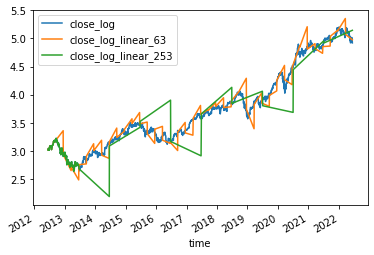

In [11]:
df.plot(x='time', y=['close_log','close_log_linear_63', 'close_log_linear_253'])

In [12]:
df.tail()

,timestamp,open,high,low,close,volumn,time,close_log,close_log_diff,close_log_diff_1,...,high_log_diff,close_log_error_253,close_log_linear_253,close_log_error_63,close_log_linear_63,value,ema20,ema12,macd,rsi
2513,2022-06-06 13:30:00,147.029999,148.570007,144.899994,146.139999,71598400,2022-06-06 13:30:00,4.984565,0.005214,-0.039319,...,0.021705,-0.158096,5.142661,0.002433,4.982132,-0.035128,149.456087,146.618510,-2.837577,45.626361
2514,2022-06-07 13:30:00,144.350006,149.000000,144.100006,148.710007,67808200,2022-06-07 13:30:00,5.001998,0.017433,0.005214,...,0.019381,-0.141323,5.143321,0.021033,4.980965,-0.018592,149.400822,146.940279,-2.460543,48.855928
2515,2022-06-08 13:30:00,148.580002,149.869995,147.460007,147.960007,53950200,2022-06-08 13:30:00,4.996942,-0.005056,0.017433,...,0.007770,-0.147040,5.143982,0.017145,4.979797,-0.052750,149.294095,147.097160,-2.196935,47.960661
2516,2022-06-09 13:30:00,147.080002,147.949997,142.529999,142.639999,69473000,2022-06-09 13:30:00,4.960324,-0.036618,-0.005056,...,-0.000068,-0.184318,5.144642,-0.018306,4.978630,-0.047336,148.801199,146.411443,-2.389756,42.071433
2517,2022-06-10 20:00:04,140.279999,140.759995,137.059998,137.130005,91262371,2022-06-10 20:00:04,4.920929,-0.039395,-0.036618,...,-0.013268,-0.224552,5.145482,-0.056216,4.977146,0.000000,147.936666,144.983530,-2.953137,37.003410


In [13]:
df.corr()['value'].sort_values()

volumn                    -0.106311
open_log_diff             -0.033990
close_log_linear_253      -0.026999
ema20                     -0.019675
open                      -0.019465
close_log_diff_1          -0.019310
ema12                     -0.018916
high                      -0.016524
low                       -0.014963
close                     -0.012739
open_log_close_log_diff   -0.010197
close_log_linear_63        0.004883
close_log_diff_2           0.006438
open_log                   0.009315
high_log                   0.012384
low_log                    0.013410
close_log                  0.015802
macd                       0.019124
close_log_error_63         0.054732
close_log_error_253        0.101494
rsi                        0.131054
high_log_diff              0.148714
low_log_diff               0.178320
close_log_diff             0.245015
value                      1.000000
Name: value, dtype: float64

In [14]:
rootdir = '../data/stocks'
stock_list = []

stock_list.append('^DJI')
stock_list.append('^OMX')

for subdir, dirs, files in os.walk(rootdir):
  for dir in dirs:
    obj =  {}
    name = dir
    stock_list.append(name)

In [15]:
def rename_dataframe(df, name):
  return df.rename(columns={'close_log': 'close_log_' + name,
                            'close_log_error_63': 'close_log_error_63_' + name,
                            'close_log_error_253': 'close_log_error_253_' + name,
                            'value': 'value_' + name,
                            'log': 'log_' + name,
                            'log_diff': 'log_diff_' + name,
                            'close_log_diff': 'close_log_diff_' + name,
                            'close_log_diff_1': 'close_log_diff_1_' + name,
                            'close_log_diff_2': 'close_log_diff_2_' + name,
                            'low_log_diff': 'low_log_diff_' + name,
                            'open_log_diff': 'open_log_diff_' + name,
                            'high_log_diff': 'high_log_diff_' + name,
                            'data': 'data_' + name,
                            'data_log': 'data_log_' + name,
                            'data_log_diff': 'data_log_diff_' + name,
                            'macd': 'macd_' + name,
                            'rsi': 'rsi_' + name
                            })

In [16]:

columns = ['time', 'close_log', 'close_log_error_63', 'close_log_error_253', 'close_log_diff', 'close_log_diff_1', 'close_log_diff_2', 'open_log_diff', 'low_log_diff', 'high_log_diff']


for i in range(0, len(stock_list)):
  name = stock_list[i]
  df1 = handle_stock(name, False)
  df1 = rename_dataframe(df1[columns], name)
  df = pd.merge_asof(df, df1, on='time')


In [17]:
df.head()

,timestamp,open,high,low,close,volumn,time,close_log,close_log_diff,close_log_diff_1,...,high_log_diff_^DJI,close_log_^OMX,close_log_error_63_^OMX,close_log_error_253_^OMX,close_log_diff_^OMX,close_log_diff_1_^OMX,close_log_diff_2_^OMX,open_log_diff_^OMX,low_log_diff_^OMX,high_log_diff_^OMX
0,2012-06-14 13:30:00,20.401428,20.482143,20.259287,20.411785,345573200,2012-06-14 13:30:00,3.016112,-0.001102,-0.006967,...,0.016059,6.879006,0.0,0.0,-0.004467,-0.011359,0.004946,-0.015766,-0.018343,0.000021
1,2012-06-15 13:30:00,20.392857,20.522142,20.341070,20.504642,335255200,2012-06-15 13:30:00,3.020651,0.004539,-0.001102,...,0.009658,6.885029,0.0,0.0,0.006023,-0.004467,-0.011359,0.003316,0.002169,0.008924
2,2012-06-18 13:30:00,20.391430,20.996071,20.370358,20.920713,440412000,2012-06-18 13:30:00,3.040740,0.020088,0.004539,...,0.001155,6.888623,0.0,0.0,0.003594,0.006023,-0.004467,0.012430,-0.005920,0.015138
3,2012-06-19 13:30:00,20.835714,21.071428,20.825001,20.978930,361404400,2012-06-19 13:30:00,3.043519,0.002779,0.020088,...,0.012256,6.907945,0.0,0.0,0.019322,0.003594,0.006023,-0.010103,-0.000163,0.020031
4,2012-06-20 13:30:00,21.007500,21.044643,20.742857,20.919287,358943200,2012-06-20 13:30:00,3.040672,-0.002847,0.002779,...,0.003099,6.922634,0.0,0.0,0.014689,0.019322,0.003594,0.025227,-0.003516,0.015801


In [18]:
def reorder(df):
  columns_indicator_value = list(filter(lambda c: 'value' in c and '^' in c, df.columns.tolist()))
  columns_stock_value = list(filter(lambda c: 'value' in c and '^' not in c, df.columns.tolist()))
  columns_non_value = list(filter(lambda c: 'value' not in c, df.columns.tolist()))
  df = df[columns_non_value + columns_stock_value + columns_indicator_value]
  return df

df = reorder(df)
df.head()

,timestamp,open,high,low,close,volumn,time,close_log,close_log_diff,close_log_diff_1,...,close_log_^OMX,close_log_error_63_^OMX,close_log_error_253_^OMX,close_log_diff_^OMX,close_log_diff_1_^OMX,close_log_diff_2_^OMX,open_log_diff_^OMX,low_log_diff_^OMX,high_log_diff_^OMX,value
0,2012-06-14 13:30:00,20.401428,20.482143,20.259287,20.411785,345573200,2012-06-14 13:30:00,3.016112,-0.001102,-0.006967,...,6.879006,0.0,0.0,-0.004467,-0.011359,0.004946,-0.015766,-0.018343,0.000021,0.023678
1,2012-06-15 13:30:00,20.392857,20.522142,20.341070,20.504642,335255200,2012-06-15 13:30:00,3.020651,0.004539,-0.001102,...,6.885029,0.0,0.0,0.006023,-0.004467,-0.011359,0.003316,0.002169,0.008924,0.027261
2,2012-06-18 13:30:00,20.391430,20.996071,20.370358,20.920713,440412000,2012-06-18 13:30:00,3.040740,0.020088,0.004539,...,6.888623,0.0,0.0,0.003594,0.006023,-0.004467,0.012430,-0.005920,0.015138,0.031627
3,2012-06-19 13:30:00,20.835714,21.071428,20.825001,20.978930,361404400,2012-06-19 13:30:00,3.043519,0.002779,0.020088,...,6.907945,0.0,0.0,0.019322,0.003594,0.006023,-0.010103,-0.000163,0.020031,0.010261
4,2012-06-20 13:30:00,21.007500,21.044643,20.742857,20.919287,358943200,2012-06-20 13:30:00,3.040672,-0.002847,0.002779,...,6.922634,0.0,0.0,0.014689,0.019322,0.003594,0.025227,-0.003516,0.015801,0.003318


In [19]:
def print_corr(n):
    print(df.corr()['value'].abs().sort_values(ascending=False)[:n])

In [20]:
#data = df[:-253].sample(frac=1).values
#X, y = data[:, 1:-len(stock_list)], data[:, -len(stock_list)]

In [21]:
#model = XGBRegressor()
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [22]:
#scores = absolute(scores)
#print('Mean MAE: %.4f (%.4f)' % (scores.mean(), scores.std()))

In [23]:
def load_indicator(name):
  path = os.path.join('../data/indicators', name)
  df = pd.read_json(os.path.join(path, 'data')).dropna()
  df['time']=pd.to_datetime(df['timestamp'],unit='s')
  return df

In [24]:
rootdir = '../data/indicators'
indicators_list = []
for subdir, dirs, files in os.walk(rootdir):
  for dir in dirs:
    name = dir
    if '=' in name:
      indicators_list.append(name)

In [25]:
# CL=F: oil
# ZB=F: bond
# GC=F: gold
indicators_list

['EURSEK=X',
 'CL=F',
 'EUR=X',
 'ZB=F',
 'GC=F',
 'HG=F',
 'ZS=F',
 'SEK=X',
 'LE=F',
 'SB=F',
 'SI=F']

In [26]:
def printna(df):
  print(df[df.isna().any(axis=1)])


In [27]:
for i in range(len(indicators_list)):
  name = indicators_list[i]
  print('merging name:' + name)
  df1 = load_indicator(name)
  df1 = df1.dropna()
  df1 = add_diff(df1)
  df1 = linear_regression(df1, 63)
  df1 = rename_dataframe(df1[['time', 'close_log', 'close_log_error_63', 'close_log_diff', 'close_log_diff_1', 'close_log_diff_2']], name)
  df = pd.merge_asof(df, df1, on='time')

merging name:EURSEK=X
merging name:CL=F


/home/ken/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ken/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ken/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


merging name:EUR=X
merging name:ZB=F
merging name:GC=F
merging name:HG=F
merging name:ZS=F
merging name:SEK=X
merging name:LE=F
merging name:SB=F
merging name:SI=F


In [28]:
df.head()

,timestamp,open,high,low,close,volumn,time,close_log,close_log_diff,close_log_diff_1,...,close_log_SB=F,close_log_error_63_SB=F,close_log_diff_SB=F,close_log_diff_1_SB=F,close_log_diff_2_SB=F,close_log_SI=F,close_log_error_63_SI=F,close_log_diff_SI=F,close_log_diff_1_SI=F,close_log_diff_2_SI=F
0,2012-06-14 13:30:00,20.401428,20.482143,20.259287,20.411785,345573200,2012-06-14 13:30:00,3.016112,-0.001102,-0.006967,...,2.994231,0.0,0.002507,-0.021848,-0.005388,3.346424,0.0,-0.018628,-0.000276,0.011712
1,2012-06-15 13:30:00,20.392857,20.522142,20.341070,20.504642,335255200,2012-06-15 13:30:00,3.020651,0.004539,-0.001102,...,3.036874,0.0,0.042643,0.002507,-0.021848,3.358081,0.0,0.011657,-0.018628,-0.000276
2,2012-06-18 13:30:00,20.391430,20.996071,20.370358,20.920713,440412000,2012-06-18 13:30:00,3.040740,0.020088,0.004539,...,3.037833,0.0,0.000959,0.042643,0.002507,3.355677,0.0,-0.002404,0.011657,-0.018628
3,2012-06-19 13:30:00,20.835714,21.071428,20.825001,20.978930,361404400,2012-06-19 13:30:00,3.043519,0.002779,0.020088,...,3.071303,0.0,0.033470,0.000959,0.042643,3.345050,0.0,-0.010627,-0.002404,0.011657
4,2012-06-20 13:30:00,21.007500,21.044643,20.742857,20.919287,358943200,2012-06-20 13:30:00,3.040672,-0.002847,0.002779,...,3.079154,0.0,0.007850,0.033470,0.000959,3.345790,0.0,0.000740,-0.010627,-0.002404


In [29]:
df = reorder(df)

In [30]:
print_corr(20)

value                       1.000000
close_log_diff              0.245015
low_log_diff                0.178320
close_log_error_63_LE=F     0.162517
high_log_diff               0.148714
close_log_error_63_SB=F     0.144811
rsi                         0.131054
close_log_LE=F              0.121992
close_log_ZB=F              0.121593
close_log_error_63_^OMX     0.119764
close_log_diff_^DJI         0.113973
close_log_error_63_CL=F     0.106542
close_log_EURSEK=X          0.106378
volumn                      0.106311
close_log_CL=F              0.105420
close_log_error_253         0.101494
close_log_error_253_^OMX    0.100330
close_log_ZS=F              0.089898
close_log_SB=F              0.087225
close_log_SI=F              0.077653
Name: value, dtype: float64


In [31]:
len(df.columns)

100

In [32]:
rootdir = '../data/fred'
fred_list = []
for subdir, dirs, files in os.walk(rootdir):
  for dir in files:
    name = dir
    fred_list.append(name)

In [33]:
fred_list

['GDP', 'M1SL', 'M2', 'CPI', 'UNRATE']

In [34]:
def load_fred(name):
  path = '../data/fred'
  df = pd.read_csv(os.path.join(path, name)).dropna()
  df['time']=pd.to_datetime(df['DATE'])
  df['data']=df.iloc[:, 1]
  df['log']=np.log(df['data'])
  df['log_diff']=df['log'].diff()
  return df.replace([np.inf, -np.inf], np.nan).dropna().iloc[:, 2:]

In [35]:
for i in range(len(fred_list)):
  name = fred_list[i]
  print('merging fred data:' + name)
  df1 = load_fred(name)
  df1 = df1.dropna()

  df1 = rename_dataframe(df1[['time', 'data','log', 'log_diff']], name)
  df = pd.merge_asof(df, df1, on='time')

merging fred data:GDP
merging fred data:M1SL
merging fred data:M2
merging fred data:CPI
merging fred data:UNRATE


/home/ken/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ken/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
df.head()

,timestamp,open,high,low,close,volumn,time,close_log,close_log_diff,close_log_diff_1,...,log_diff_M1SL,data_M2,log_M2,log_diff_M2,data_CPI,log_CPI,log_diff_CPI,data_UNRATE,log_UNRATE,log_diff_UNRATE
0,2012-06-14 13:30:00,20.401428,20.482143,20.259287,20.411785,345573200,2012-06-14 13:30:00,3.016112,-0.001102,-0.006967,...,0.00843,9987.3,9.209070,0.004828,0.302103,-1.196987,-0.921834,8.2,2.104134,0.0
1,2012-06-15 13:30:00,20.392857,20.522142,20.341070,20.504642,335255200,2012-06-15 13:30:00,3.020651,0.004539,-0.001102,...,0.00843,9987.3,9.209070,0.004828,0.302103,-1.196987,-0.921834,8.2,2.104134,0.0
2,2012-06-18 13:30:00,20.391430,20.996071,20.370358,20.920713,440412000,2012-06-18 13:30:00,3.040740,0.020088,0.004539,...,0.00843,9986.5,9.208989,-0.000080,0.302103,-1.196987,-0.921834,8.2,2.104134,0.0
3,2012-06-19 13:30:00,20.835714,21.071428,20.825001,20.978930,361404400,2012-06-19 13:30:00,3.043519,0.002779,0.020088,...,0.00843,9986.5,9.208989,-0.000080,0.302103,-1.196987,-0.921834,8.2,2.104134,0.0
4,2012-06-20 13:30:00,21.007500,21.044643,20.742857,20.919287,358943200,2012-06-20 13:30:00,3.040672,-0.002847,0.002779,...,0.00843,9986.5,9.208989,-0.000080,0.302103,-1.196987,-0.921834,8.2,2.104134,0.0


In [37]:
print_corr(20)

value                       1.000000
close_log_diff              0.245015
low_log_diff                0.178320
close_log_error_63_LE=F     0.162517
high_log_diff               0.148714
close_log_error_63_SB=F     0.144811
log_diff_CPI                0.144039
rsi                         0.131054
data_UNRATE                 0.127848
close_log_LE=F              0.121992
close_log_ZB=F              0.121593
close_log_error_63_^OMX     0.119764
close_log_diff_^DJI         0.113973
close_log_error_63_CL=F     0.106542
close_log_EURSEK=X          0.106378
volumn                      0.106311
close_log_CL=F              0.105420
close_log_error_253         0.101494
close_log_error_253_^OMX    0.100330
log_UNRATE                  0.096751
Name: value, dtype: float64


In [39]:
df = reorder(df)

In [40]:
df.drop(columns=['time'], inplace=True)

In [41]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2515 entries, 0 to 2514
Columns: 114 entries, timestamp to value
dtypes: datetime64[ns](1), float64(112), int64(1)
memory usage: 2.2 MB


In [42]:
df.tail()

,timestamp,open,high,low,close,volumn,close_log,close_log_diff,close_log_diff_1,close_log_diff_2,...,data_M2,log_M2,log_diff_M2,data_CPI,log_CPI,log_diff_CPI,data_UNRATE,log_UNRATE,log_diff_UNRATE,value
2510,2022-06-06 13:30:00,147.029999,148.570007,144.899994,146.139999,71598400,4.984565,0.005214,-0.039319,0.016671,...,21724.9,9.986214,-0.001159,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.035128
2511,2022-06-07 13:30:00,144.350006,149.000000,144.100006,148.710007,67808200,5.001998,0.017433,0.005214,-0.039319,...,21724.9,9.986214,-0.001159,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.018592
2512,2022-06-08 13:30:00,148.580002,149.869995,147.460007,147.960007,53950200,4.996942,-0.005056,0.017433,0.005214,...,21724.9,9.986214,-0.001159,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.052750
2513,2022-06-09 13:30:00,147.080002,147.949997,142.529999,142.639999,69473000,4.960324,-0.036618,-0.005056,0.017433,...,21724.9,9.986214,-0.001159,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.047336
2514,2022-06-10 20:00:04,140.279999,140.759995,137.059998,137.130005,91262371,4.920929,-0.039395,-0.036618,-0.005056,...,21724.9,9.986214,-0.001159,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,0.000000


In [188]:

data = df[:-253].sample(frac=1).values
X, y = data[:, 1:-1], data[:, -1]
model = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.4f (%.4f)' % (scores.mean(), scores.std()))

KeyboardInterrupt: 

In [43]:
# first 20 columns: -0.03


column_list = df.corr()['value'].sort_values(ascending=False)[1:30].index.to_list()

In [44]:
column_list

['close_log_diff',
 'low_log_diff',
 'close_log_error_63_LE=F',
 'high_log_diff',
 'log_diff_CPI',
 'rsi',
 'data_UNRATE',
 'close_log_ZB=F',
 'close_log_error_63_^OMX',
 'close_log_diff_^DJI',
 'close_log_error_63_CL=F',
 'close_log_EURSEK=X',
 'close_log_error_253',
 'close_log_error_253_^OMX',
 'log_UNRATE',
 'log_diff_M1SL',
 'log_diff_UNRATE',
 'close_log_SEK=X',
 'low_log_diff_^DJI',
 'log_M2',
 'close_log_error_253_^DJI',
 'high_log_diff_^DJI',
 'close_log_diff_2_^OMX',
 'close_log_diff_1_SB=F',
 'log_M1SL',
 'close_log_error_63',
 'log_CPI',
 'data_M2',
 'close_log_diff_^OMX']

In [45]:
# Numerical pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

num_pipeline = Pipeline([ 
 ('imputer', SimpleImputer(strategy="mean")),
 ('std_scaler', StandardScaler() )])

num_pipeline_normalizer = Pipeline([ 
 ('imputer', SimpleImputer(strategy="mean")),
 ('normalizer', Normalizer() )])

# categorical pipeline
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([ 
 ('imputer', SimpleImputer(strategy="most_frequent")),
 ('OneHotEncoder', OneHotEncoder())
 ])


from sklearn.compose import ColumnTransformer

num_attribs = column_list
cat_attribs = []

# preprocess pipeline
from sklearn.compose import ColumnTransformer
column_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", cat_pipeline, cat_attribs)])
column_pipeline_normal = ColumnTransformer([("num", num_pipeline_normalizer, num_attribs),("cat", cat_pipeline, cat_attribs)])

In [46]:
data = df[:-253]
X, y = data.iloc[:, 1:-1], data.iloc[:, -1]

In [47]:
column_pipeline.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['close_log_diff', 'low_log_diff',
                                  'close_log_error_63_LE=F', 'high_log_diff',
                                  'log_diff_CPI', 'rsi', 'data_UNRATE',
                                  'close_log_ZB=F', 'close_log_error_63_^OMX',
                                  'close_log_diff_^DJI',
                                  'close_log_error_63_CL=F',
                                  'close_log_EURSEK=X', 'close_log_...
                                  'log_diff_M1SL', 'log_diff_UNRATE',
                                  'close_log_SEK=X', 'low_log_diff_^DJI',
                                  'log_M2', 'close_log_error_253_^DJI',
                                  'high_log_diff_^DJI', 'close_log_diff_2_^OMX',
                                  'close_log_diff_1_SB=F', 'log_M1SL',
                                  'close_log_error_63', 'log_CPI', 'data_M2',
                                  'close_log_diff_^OMX']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder())]),
                                 [])])

In [74]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from tempfile import mkdtemp
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel


cachedir = mkdtemp()
full_pipeline = Pipeline([
    ('transform', column_pipeline),
    ('pca', PCA()),
    ('regress', 'passthrough')
], memory=cachedir)

N_COMPONENTS = (2, len(column_list)-1)
N_FEATURES_OPTIONS = [2,4,8]
GAMMA_OPTIONS = [0.5, 1]
N_ITER=16
N_ITER_SMALL=2

# param_grid = [({
#     "pca__n_components": N_COMPONENTS,
#     "regress": [RandomForestRegressor()],
#     "regress__n_estimators":  (10, 100),
#     "regress__criterion": ["squared_error"],
#     "regress__max_depth": (10,20),
#     "regress__min_samples_split": (2,16),
# }, N_ITER),
# ({
#     "pca__n_components": N_COMPONENTS,
#     "regress": [XGBRegressor()],
#     "regress__gamma": (0.5, 5),
#     "regress__subsample": (0.6, 1.0),
#     'regress__min_child_weight': (1, 10),
#     "regress__colsample_bytree": (0.6, 1.0),
#     "regress__max_depth": (3, 5)
# }, N_ITER),
param_grid = [({
    "pca__n_components": N_COMPONENTS,
    "regress": [svm.SVR()],
    "regress__C": (1,10),
    "regress__gamma": ["scale", "auto"],
    "regress__kernel": ["linear", "poly", "rbf", "sigmoid"]
}, N_ITER),
({
    "pca__n_components": N_COMPONENTS,
    "regress": [lgb.LGBMRegressor()],
    "regress__num_leaves": (31, 127),
    "regress__reg_alpha": [0.1, 0.5],
    "regress__min_data_in_leaf": [30, 50, 100, 300, 400],
    "regress__lambda_l1": [0, 1, 1.5],
    "regress__lambda_l2": [0, 1]
}, N_ITER)]

In [75]:
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import os
from skopt import dump, load

def cb(v):
    print('test')
    print(v)

PKL_FILENAME='./grid.pkl'
#grid = GridSearchCV(full_pipeline, n_jobs=1, cv=3, scoring="accuracy", param_grid=param_grid)
if os.path.exists(PKL_FILENAME):
    grid = load(PKL_FILENAME)
else:
    grid =  BayesSearchCV(full_pipeline, n_jobs=-1, cv=5, scoring="neg_mean_absolute_error", search_spaces=param_grid, verbose=3)
    grid.fit(X, y)
    dump(grid, 'grid.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/ken/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/ken/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/ken/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [76]:
df['value'].mean()

0.006675505680741446

In [77]:
df['value'].std()

0.039532820499415276

In [78]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_regress,param_regress__C,param_regress__gamma,param_regress__kernel,param_regress__lambda_l1,...,param_regress__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.101425,1.132902,0.006290,0.000441,3,SVR(),8,scale,poly,NaN,...,NaN,"{'pca__n_components': 3, 'regress': SVR(), 're...",-0.032725,-0.028889,-0.029958,-0.032434,-0.134898,-0.051781,0.041584,28
1,0.068532,0.024522,0.007341,0.002516,15,SVR(),4,scale,poly,NaN,...,NaN,"{'pca__n_components': 15, 'regress': SVR(), 'r...",-0.034611,-0.029586,-0.033726,-0.033485,-2.855280,-0.597338,1.128973,30
2,0.068993,0.012662,0.010341,0.003377,17,SVR(),4,scale,rbf,NaN,...,NaN,"{'pca__n_components': 17, 'regress': SVR(), 'r...",-0.031750,-0.029339,-0.031226,-0.034712,-0.040429,-0.033491,0.003874,13
3,0.667619,0.308997,0.005849,0.001081,20,SVR(),7,scale,linear,NaN,...,NaN,"{'pca__n_components': 20, 'regress': SVR(), 'r...",-0.042712,-0.038057,-0.046304,-0.043330,-0.072696,-0.048620,0.012325,26
4,0.284141,0.065538,0.007089,0.002538,2,SVR(),3,auto,linear,NaN,...,NaN,"{'pca__n_components': 2, 'regress': SVR(), 're...",-0.031656,-0.027906,-0.027979,-0.031613,-0.046472,-0.033125,0.006875,11
5,0.049184,0.012799,0.010177,0.004836,15,SVR(),4,scale,poly,NaN,...,NaN,"{'pca__n_components': 15, 'regress': SVR(), 'r...",-0.034611,-0.029586,-0.033726,-0.033485,-2.855280,-0.597338,1.128973,30
6,0.066845,0.021105,0.012428,0.004994,5,SVR(),2,scale,rbf,NaN,...,NaN,"{'pca__n_components': 5, 'regress': SVR(), 're...",-0.032874,-0.029844,-0.029975,-0.034769,-0.043740,-0.034240,0.005097,21
7,0.701244,0.391098,0.008324,0.002575,23,SVR(),8,scale,linear,NaN,...,NaN,"{'pca__n_components': 23, 'regress': SVR(), 'r...",-0.037402,-0.038965,-0.050340,-0.045500,-0.073468,-0.049135,0.013022,27
8,0.076996,0.027752,0.008208,0.003795,24,SVR(),6,scale,poly,NaN,...,NaN,"{'pca__n_components': 24, 'regress': SVR(), 'r...",-0.032307,-0.030193,-0.034060,-0.033930,-2.133203,-0.452739,0.840233,29
9,0.550194,0.096086,0.086766,0.005699,9,SVR(),8,scale,sigmoid,NaN,...,NaN,"{'pca__n_components': 9, 'regress': SVR(), 're...",-65.004071,-44.752008,-34.662857,-42.202605,-225.749616,-82.474231,72.337735,32


In [85]:
best_estimator = grid.best_estimator_

X_transformed = best_estimator[0].transform(X)
X_PCA = best_estimator[1].fit(X_transformed)

In [87]:
X_transformed.shape

(2262, 29)

In [95]:
best_estimator[1].components_[0].argsort()[::-1]

array([19, 27, 24, 11, 17,  7, 20, 13,  4,  5,  0,  3, 21,  8,  9,  1, 18,
       12, 28, 15, 26, 25,  2, 22, 10, 23,  6, 16, 14])

In [103]:
best_estimator[1].components_[0]

array([ 0.14050629,  0.11866074,  0.06462696,  0.13757994,  0.15330113,
        0.15120571,  0.0045146 ,  0.26540411,  0.13176564,  0.1294959 ,
        0.03410279,  0.32577014,  0.10701592,  0.20574072, -0.03600716,
        0.09953398,  0.00227506,  0.2910802 ,  0.10761838,  0.3856137 ,
        0.2459737 ,  0.13536016,  0.03502599,  0.01168039,  0.35118231,
        0.08045867,  0.08409722,  0.38422875,  0.10067272])

In [106]:
pd.DataFrame({'column': column_list, 'weight': best_estimator[1].components_[0]}).sort_values(by='weight')

,column,weight
14,log_UNRATE,-0.036007
16,log_diff_UNRATE,0.002275
6,data_UNRATE,0.004515
23,close_log_diff_1_SB=F,0.011680
10,close_log_error_63_CL=F,0.034103
22,close_log_diff_2_^OMX,0.035026
2,close_log_error_63_LE=F,0.064627
25,close_log_error_63,0.080459
26,log_CPI,0.084097
15,log_diff_M1SL,0.099534


In [107]:
pd.DataFrame({'column': column_list, 'weight': best_estimator[1].components_[1]}).sort_values(by='weight')

,column,weight
9,close_log_diff_^DJI,-0.368930
18,low_log_diff_^DJI,-0.365947
1,low_log_diff,-0.364145
0,close_log_diff,-0.357546
3,high_log_diff,-0.298701
21,high_log_diff_^DJI,-0.288045
28,close_log_diff_^OMX,-0.277848
5,rsi,-0.133188
14,log_UNRATE,-0.098158
25,close_log_error_63,-0.094623


In [89]:
best_estimator[1].components_[0]

array([ 0.14050629,  0.11866074,  0.06462696,  0.13757994,  0.15330113,
        0.15120571,  0.0045146 ,  0.26540411,  0.13176564,  0.1294959 ,
        0.03410279,  0.32577014,  0.10701592,  0.20574072, -0.03600716,
        0.09953398,  0.00227506,  0.2910802 ,  0.10761838,  0.3856137 ,
        0.2459737 ,  0.13536016,  0.03502599,  0.01168039,  0.35118231,
        0.08045867,  0.08409722,  0.38422875,  0.10067272])

In [40]:
y_pred = model_dji.predict(X_test)

In [41]:
y_pred.shape

(253,)

In [42]:
df_new = pd.DataFrame({'y_pred': y_pred, 'y': y_test, 'close_log_^DJI': df[-253:]['close_log_^DJI'], 'time': data_test[:, 0]})

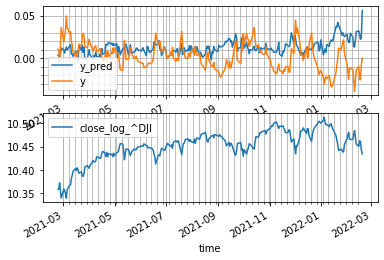

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0 = df_new.plot(ax=axes[0], x='time', y=['y_pred','y'])
xtick = pd.date_range( start=df_new['time'].min(), end=df_new['time'].max(), freq='W' )
axes[0].set_xticks(xtick, minor=True)
axes[0].grid('on', which='minor', axis='x')
axes[0].grid('off', which='major', axis='x')
y_start = int(min(df_new['y_pred'].min(), df_new['y'].min()) * 100)
y_end   = int(max(df_new['y'].max(), df_new['y'].max()) * 100)

axes[0].set_yticks([item * 0.01 for item in range(y_start, y_end)], minor=True)
axes[0].grid('on', which='minor', axis='y')
axes[0].grid('off', which='major', axis='y')
df[-253:].plot(ax=axes[1], x='time', y='close_log_^DJI')
axes[1].set_xticks(xtick, minor=True)
axes[1].grid('on', which='minor', axis='x')
axes[1].grid('off', which='major', axis='x')

#axes[0].grid('on', which='minor', axis='x' )

In [46]:
df.tail()

,time,close_log_^DJI,close_log_error_63_^DJI,close_log_error_253_^DJI,close_log_diff_^DJI,close_log_diff_1_^DJI,close_log_diff_2_^DJI,open_log_diff_^DJI,low_log_diff_^DJI,high_log_diff_^DJI,...,log_M2,log_diff_M2,data_CPI,log_CPI,log_diff_CPI,data_UNRATE,log_UNRATE,log_diff_UNRATE,value_^DJI,value_^OMX
2510,2022-02-14 14:30:00,10.450631,-0.078606,-0.286967,-0.004960,-0.014391,-0.014828,-0.001255,-0.012566,0.000187,...,9.991714,-0.001226,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.009852,-0.011923
2511,2022-02-15 14:30:00,10.462784,-0.066937,-0.275816,0.012154,-0.004960,-0.014391,0.003466,0.003466,0.013837,...,9.991714,-0.001226,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.024450,-0.033436
2512,2022-02-16 14:30:00,10.461224,-0.068983,-0.278379,-0.001561,0.012154,-0.004960,-0.001058,-0.009944,0.001521,...,9.991714,-0.001226,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.025433,-0.028033
2513,2022-02-17 14:30:00,10.443251,-0.087440,-0.297354,-0.017972,-0.001561,0.012154,-0.002172,-0.019892,-0.002172,...,9.991714,-0.001226,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,-0.008289,-0.014201
2514,2022-02-18 17:58:18,10.434962,-0.096285,-0.306791,-0.008289,-0.017972,-0.001561,-0.000046,-0.008755,0.003246,...,9.991714,-0.001226,0.307252,-1.180088,-0.469475,3.9,1.360977,-0.074108,0.000000,0.000000


In [159]:
profit = 0
state = 0
close_log_diff = df['close_log_diff_^DJI'][-253:]
low_log_diff = df['low_log_diff_^DJI'][-253:]
open_log_diff = df['open_log_diff_^DJI'][-253:]
security = 0
loss_stop = -0.04
hold_days = 0
security_list = []
profit_list = []
bid_times = 0
bid_loss_stop = 0
for i in range(len(y_pred)):
  
  security += close_log_diff.iloc[i]
  if state == 1:
    hold_days += 1
    change = close_log_diff.iloc[i]
    low_diff = low_log_diff.iloc[i]
    open_diff = open_log_diff.iloc[i]
    if low_diff < loss_stop:
      change = min(loss_stop, open_diff)
      state = 0
      profit += change
      security_list.append(security)
      profit_list.append(profit)
      bid_times += 1
      bid_loss_stop += 1
      
      continue
    else:
      profit += change
  if y_pred[i] > 0.03 and state == 0:
    state = 1
    bid_times += 1
  elif y_pred[i] <= 0.01 and state == 1:
    state = 0
    bid_times += 1
  security_list.append(security)
  profit_list.append(profit)

print(profit)
print(security)
print(hold_days)
print('bid_times=',bid_times, 'loss_stops=', bid_loss_stop)
print(len(security_list))
print(len(profit_list))
print(len(y_pred))

0.11621388073907646
0.07739945184927421
223
bid_times= 5 loss_stops= 0
253
253
253


<AxesSubplot:xlabel='time'>

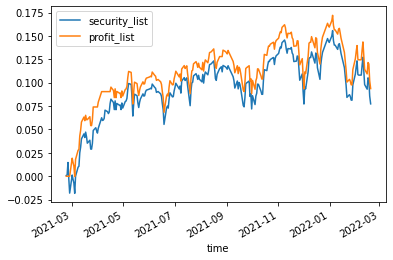

In [92]:
df_new['security_list']=security_list
df_new['profit_list']=profit_list
df_new.plot(x='time', y=['security_list', 'profit_list'])

In [101]:
model_omx = XGBRegressor()
data_test = df[-253:].values
X, y = data[:, 1:-len(stock_list)], data[:, -1]
X_test, y_test = data_test[:, 1:-len(stock_list)], data_test[:, -1]
model_omx.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [103]:
y_pred = model_omx.predict(X_test)
df_new = pd.DataFrame({'y_pred': y_pred, 'y': y_test, 'close_log_^OMX': df[-253:]['close_log_^OMX'], 'time': data_test[:, 0]})

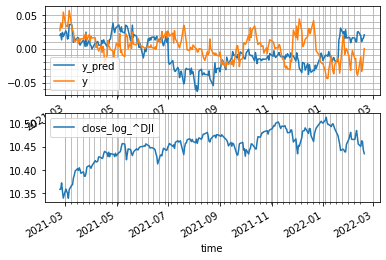

In [105]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0 = df_new.plot(ax=axes[0], x='time', y=['y_pred','y'])
xtick = pd.date_range( start=df_new['time'].min(), end=df_new['time'].max(), freq='W' )
axes[0].set_xticks(xtick, minor=True)
axes[0].grid('on', which='minor', axis='x')
axes[0].grid('off', which='major', axis='x')
y_start = int(min(df_new['y_pred'].min(), df_new['y'].min()) * 100)
y_end   = int(max(df_new['y'].max(), df_new['y'].max()) * 100)

axes[0].set_yticks([item * 0.01 for item in range(y_start, y_end)], minor=True)
axes[0].grid('on', which='minor', axis='y')
axes[0].grid('off', which='major', axis='y')
df[-253:].plot(ax=axes[1], x='time', y='close_log_^DJI')
axes[1].set_xticks(xtick, minor=True)
axes[1].grid('on', which='minor', axis='x')
axes[1].grid('off', which='major', axis='x')

In [107]:
import json
import re



def loadScbData(scbData):
  name = scbData['name']
  time_index = scbData['time_index']
  value_index = scbData['value_index']
  f = open('../data/scb/' + name)
  data = json.load(f)
  f.close()
  
  def toMonth(a):
    match = re.search("([0-9]{4})M([0-9]{2})", a[time_index])
    return match.group(1) + match.group(2)

  df1 = pd.read_json(json.dumps(data['data']))
  df1['month'] = df1['key'].apply(toMonth)
  df1['time']=pd.to_datetime(df1['month'], format='%Y%m')
  df1['data'] = df1['values'].apply(lambda x: float(x[value_index]))
  df1['data_log'] = np.log(df1['data'])
  df1['data_log_diff'] = df1['data_log'].diff()
  df1 = df1.dropna()
  df1 = rename_dataframe(df1[['time', 'data', 'data_log', 'data_log_diff']], name)
  return df1

In [108]:
scb_data_list = [{
    'name': 'm1',
    'time_index': 1,
    'value_index': 0
  }, {
    'name': 'm3',
    'time_index': 1,
    'value_index': 0
  }, {
    'name': 'cpi',
    'time_index': 0,
    'value_index': 1
  }
]

for scb_data in scb_data_list:
  print(scb_data)
  print('Adding ' + scb_data['name'])
  df1 = loadScbData(scb_data)
  df = pd.merge_asof(df, df1, on='time')

{'name': 'm1', 'time_index': 1, 'value_index': 0}
Adding m1
{'name': 'm3', 'time_index': 1, 'value_index': 0}
Adding m3
{'name': 'cpi', 'time_index': 0, 'value_index': 1}
Adding cpi


In [109]:
df = reorder(df)

In [110]:
df.head()

,time,close_log_^DJI,close_log_error_63_^DJI,close_log_error_253_^DJI,close_log_diff_^DJI,close_log_diff_1_^DJI,close_log_diff_2_^DJI,open_log_diff_^DJI,low_log_diff_^DJI,high_log_diff_^DJI,...,data_log_m1,data_log_diff_m1,data_m3,data_log_m3,data_log_diff_m3,data_cpi,data_log_cpi,data_log_diff_cpi,value_^DJI,value_^OMX
0,2012-02-24 14:30:00,9.471392,0.0,0.0,-0.000134,0.003551,-0.002086,-0.000269,-0.002630,0.002241,...,14.278345,-0.016695,2366737.0,14.677023,-0.011872,313.92,5.749138,0.006616,0.001675,-0.004926
1,2012-02-27 14:30:00,9.471281,0.0,0.0,-0.000111,-0.000134,0.003551,-0.000140,-0.007760,0.003427,...,14.278345,-0.016695,2366737.0,14.677023,-0.011872,313.92,5.749138,0.006616,0.003635,0.003347
2,2012-02-28 14:30:00,9.473098,0.0,0.0,0.001817,-0.000111,-0.000134,-0.000367,-0.002212,0.003077,...,14.278345,-0.016695,2366737.0,14.677023,-0.011872,313.92,5.749138,0.006616,0.001572,-0.005902
3,2012-02-29 14:30:00,9.469011,0.0,0.0,-0.004087,0.001817,-0.000111,0.000023,-0.005819,0.003886,...,14.278345,-0.016695,2366737.0,14.677023,-0.011872,313.92,5.749138,0.006616,0.005554,-0.007570
4,2012-03-01 14:30:00,9.471188,0.0,0.0,0.002177,-0.004087,0.001817,0.000017,-0.000696,0.006204,...,14.282935,0.004590,2374874.0,14.680455,0.003432,314.80,5.751938,0.002799,0.003954,-0.014480


In [111]:
# check DJI and OMX
for i in range(2):
  name = df.columns[-1-i]
  print('Start check stock ' + name)
  data = df[:-253].sample(frac=1).values
  X, y = data[:, 1:-len(stock_list)], data[:, -1-i]
  model = XGBRegressor()
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  scores = absolute(scores)
  print('Mean MAE: %.4f (%.4f)' % (scores.mean(), scores.std()))

Start check stock value_^OMX
Mean MAE: 0.0076 (0.0005)
Start check stock value_^DJI
Mean MAE: 0.0063 (0.0006)


In [612]:




scores

array([0.00754793, 0.00751677, 0.00654866, 0.00741697, 0.00709828,
       0.00757491, 0.00695814, 0.00764097, 0.0070172 , 0.00687084,
       0.00734826, 0.00689969, 0.00832105, 0.00790597, 0.00686411,
       0.00635945, 0.00635014, 0.00728448, 0.00761762, 0.00755848,
       0.00645437, 0.00681979, 0.00656733, 0.00826157, 0.00674195,
       0.00755364, 0.0069382 , 0.00738765, 0.00633216, 0.00660739])

In [112]:
df.corr().iloc[:,-1].sort_values()

close_log_error_63_^DJI       -0.126157
close_log_^OMX                -0.083295
low_log_diff_^OMX             -0.078760
close_log_CL=F                -0.067314
close_log_error_253_^DJI      -0.065982
open_log_diff_^OMX            -0.054777
close_log_EUR=X               -0.053335
data_log_diff_cpi             -0.050260
log_diff_GDP                  -0.049074
close_log_error_63_CL=F       -0.047645
low_log_diff_^DJI             -0.041078
close_log_diff_^OMX           -0.039733
close_log_error_63_EUR=X      -0.037635
close_log_diff_2_^DJI         -0.034081
close_log_^DJI                -0.029134
close_log_diff_1_^DJI         -0.028012
close_log_error_63_GC=F       -0.026292
close_log_diff_1_^OMX         -0.022521
close_log_error_253_^OMX      -0.020705
close_log_SEK=X               -0.020094
close_log_error_63_SEK=X      -0.013054
data_GDP                      -0.011706
open_log_diff_^DJI            -0.011358
log_GDP                       -0.010582
close_log_diff_2_GC=F         -0.005634


In [113]:
model_omx = XGBRegressor()
data_test = df[-253:].values
X, y = data[:, 1:-len(stock_list)], data[:, -1]
X_test, y_test = data_test[:, 1:-len(stock_list)], data_test[:, -1]
model_omx.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [114]:
y_pred = model_omx.predict(X_test)
df_new = pd.DataFrame({'y_pred': y_pred, 'y': y_test, 'close_log_^OMX': df[-253:]['close_log_^OMX'], 'time': data_test[:, 0]})

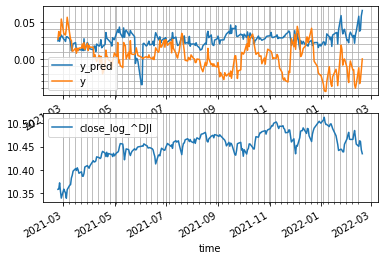

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0 = df_new.plot(ax=axes[0], x='time', y=['y_pred','y'])
xtick = pd.date_range( start=df_new['time'].min(), end=df_new['time'].max(), freq='W' )
axes[0].set_xticks(xtick, minor=True)
axes[0].grid('on', which='minor', axis='x')
axes[0].grid('off', which='major', axis='x')
y_start = int(min(df_new['y_pred'].min(), df_new['y'].min()) * 100)
y_end   = int(max(df_new['y'].max(), df_new['y'].max()) * 100)

axes[0].set_yticks([item * 0.01 for item in range(y_start, y_end)], minor=True)
axes[0].grid('on', which='minor', axis='y')
axes[0].grid('off', which='major', axis='y')
df[-253:].plot(ax=axes[1], x='time', y='close_log_^DJI')
axes[1].set_xticks(xtick, minor=True)
axes[1].grid('on', which='minor', axis='x')
axes[1].grid('off', which='major', axis='x')

In [149]:
profit = 0
state = 0
close_log_diff = df['close_log_diff_^OMX'][-253:]
low_log_diff = df['low_log_diff_^OMX'][-253:]
open_log_diff = df['open_log_diff_^OMX'][-253:]
security = 0
loss_stop = -0.001
hold_days = 0
security_list = []
profit_list = []
bid_times = 0
bid_loss_stop = 0
for i in range(len(y_pred)):
  
  security += close_log_diff.iloc[i]
  if state == 1:
    hold_days += 1
    change = close_log_diff.iloc[i]
    low_diff = low_log_diff.iloc[i]
    open_diff = open_log_diff.iloc[i]
    if low_diff < loss_stop:
      change = min(loss_stop, open_diff)
      state = 0
      profit += change
      security_list.append(security)
      profit_list.append(profit)
      bid_times += 1
      bid_loss_stop += 1
      
      continue
    else:
      profit += change
  if y_pred[i] > 0.05 and state == 0:
    state = 1
    bid_times += 1
  elif y_pred[i] <= 0.04 and state == 1:
    state = 0
    bid_times += 1
  security_list.append(security)
  profit_list.append(profit)

print(profit)
print(security)
print(hold_days)
print('bid_times=',bid_times, 'loss_stops=', bid_loss_stop)
print(len(security_list))
print(len(profit_list))
print(len(y_pred))

0.024122142890435683
0.08313679696618959
4
bid_times= 6 loss_stops= 2
253
253
253
